In [1]:
from ecpp import atkin_morain, trial_division
from miller_rabin import miller_rabin, miller_rabin_once

from joblib import Parallel, delayed
from tqdm import tqdm_notebook
from random import randint
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nzmath import prime

sns.set(context='talk')
%matplotlib inline

# Ограничение на использование

In [2]:
def time_run(func, *args, **kwargs):
    start = time.time()
    res = func(*args, **kwargs)
    return res, time.time() - start

In [5]:
primet = [0]
composite = [0]
prime_trial = [0]
composite_trial = [0]
lists = [primet, composite, prime_trial, composite_trial]

power_start = 5
power_end = 100
threshold = 10

powers = list(range(power_start, power_end))
for power in tqdm_notebook(powers):
    num = 10**power
    prime_num = prime.nextPrime(num)

    if not primet or primet[-1] < threshold:
        primet.append(time_run(atkin_morain, prime_num)[1])
    if not prime_trial or prime_trial[-1] < threshold:
        prime_trial.append(time_run(trial_division, prime_num)[1])

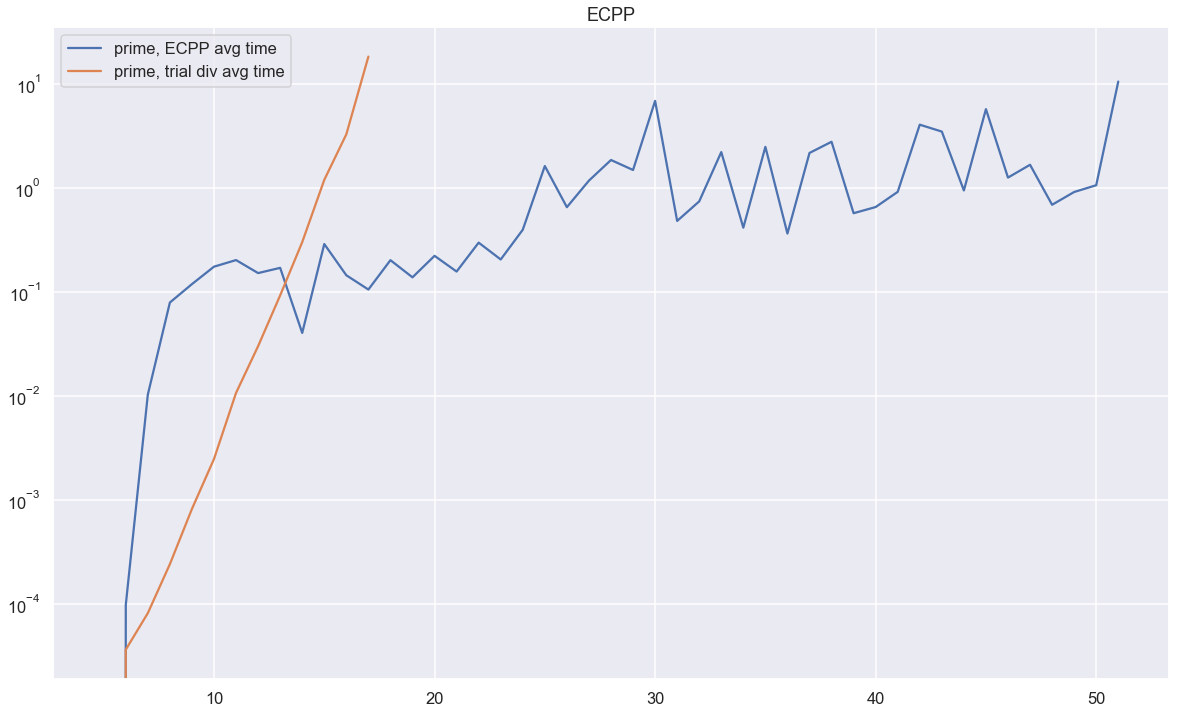

In [6]:
plt.figure(figsize=(20, 12))
plt.title('ECPP')

plt.semilogy(powers[:len(primet)], primet, label='prime, ECPP avg time')
plt.semilogy(powers[:len(prime_trial)], prime_trial, label='prime, trial div avg time')
plt.legend();

In [15]:
for i in range(5, 20, 5):
    print(i, prime_trial[i - 4], primet[i - 4])
    
for i in range(20, 55, 5):
    print(i, '------------', primet[i - 4])

(5, 3.600120544433594e-05, 9.679794311523438e-05)
(10, 0.010603904724121094, 0.20072603225708008)
(15, 3.2503740787506104, 0.14336705207824707)
(20, '------------', 0.1556859016418457)
(25, '------------', 0.6475331783294678)
(30, '------------', 0.47751808166503906)
(35, '------------', 0.3609578609466553)
(40, '------------', 0.9090290069580078)
(45, '------------', 1.2466580867767334)
(50, '------------', 10.454469919204712)


# Скорость работы

In [3]:
from nzmath import prime

power_start = 1
power_end = 18
in_bucket = 3
threshold = 10

primet = []
composite = []
prime_trial = []
composite_trial = []
lists = [primet, composite, prime_trial, composite_trial]

powers = list(range(power_start, power_end))
for power in tqdm_notebook(powers):
    left, right = 10**power, 10**(power + 1)
    
    for li in lists:
        li.append(0)
        
    if power == 16:
        in_bucket = 1
        
    for _ in range(in_bucket):
        while True:
            num = randint(left, right)
            is_prime, trial_duration = time_run(trial_division, num)
            if is_prime:
                continue
            
            prime_num = prime.nextPrime(num)
            if num >= right:
                continue
                
            if not composite or composite[-1] < threshold:
                composite[-1] += time_run(miller_rabin, num, 20)[1]
            if not primet or primet[-1] < threshold:
                primet[-1] += time_run(atkin_morain, prime_num)[1]
            if (not composite_trial or composite_trial[-1] < threshold):
                composite_trial[-1] += time_run(trial_division, num)[1]
            if (not prime_trial or prime_trial[-1] < threshold):
                prime_trial[-1] += time_run(trial_division, num)[1]
            break
    
    for li in lists:
        li[-1] /= in_bucket
        if li[-1] == 0:
            li[-1] = 1000
    
for li in lists:
    if li[-1] == 1000:
        li.pop()

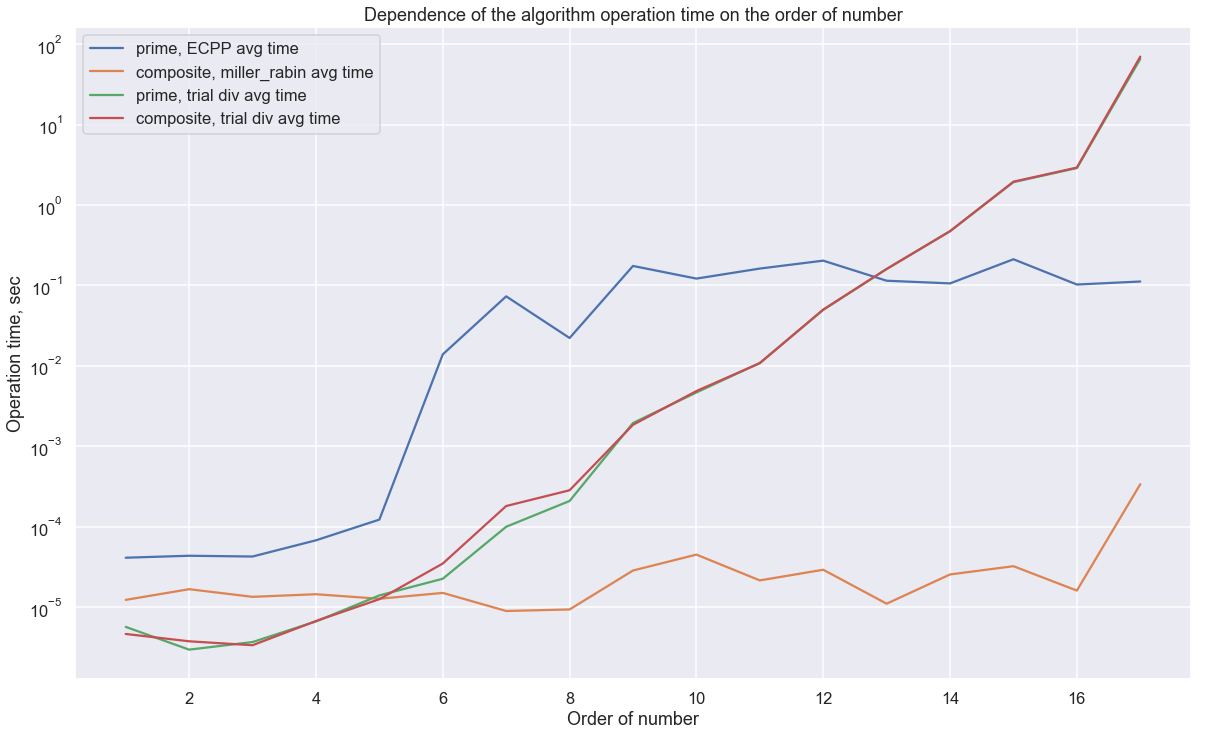

In [7]:
import numpy as np
from math import log

plt.figure(figsize=(20, 12))
plt.title('Dependence of the algorithm operation time on the order of number')
plt.xlabel('Order of number')
plt.ylabel('Operation time, sec')

plt.semilogy(powers[:len(primet)], primet, label='prime, ECPP avg time')
plt.semilogy(powers[:len(composite)], composite, label='composite, miller_rabin avg time')
plt.semilogy(powers[:len(prime_trial)], prime_trial, label='prime, trial div avg time')
plt.semilogy(powers[:len(composite_trial)], composite_trial, label='composite, trial div avg time')
plt.legend();

# Исследование числа свидетелей

In [14]:
from math import sqrt

def get_factorization(n):
    factors = []
    for i in range(2, int(sqrt(n)) + 1):
        if n % i == 0:
            factors.append([i, 0])
            while n % i == 0:
                n /= i
                factors[-1][1] += 1
    if n != 1:
        factors.append([n, 1])
    return factors

In [52]:
bound = 10**4

def witness_fraction(n):
    if trial_division(n):
        return [0, []]
    
    fraction = 0
    for a in range(1, n):
        if not miller_rabin_once(n, a):
            fraction += 1
    factorization = np.array(get_factorization(n))
    return [fraction / float(n - 1), len(factorization), factorization.sum(0)[1], (factorization[:, 1] + 1).prod()]
    

%time fractions_of_witnesses = Parallel(n_jobs=2)(delayed(witness_fraction)(n) for n in range(5, bound, 2))
fractions_of_witnesses = [x for x in fractions_of_witnesses if x[0] != 0]

CPU times: user 414 ms, sys: 146 ms, total: 560 ms
Wall time: 32.8 s


(0.13147328579945758, 5.226849319489981e-16)


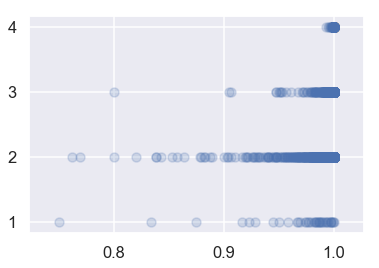

In [53]:
import scipy.stats as sps

fractions_of_witnesses = np.array(fractions_of_witnesses)
plt.scatter(fractions_of_witnesses[:, 0], fractions_of_witnesses[:, 1], alpha=0.2);
print(sps.pearsonr(fractions_of_witnesses[:, 0], fractions_of_witnesses[:, 1]))

(0.12235558802636104, 4.716991900663629e-14)


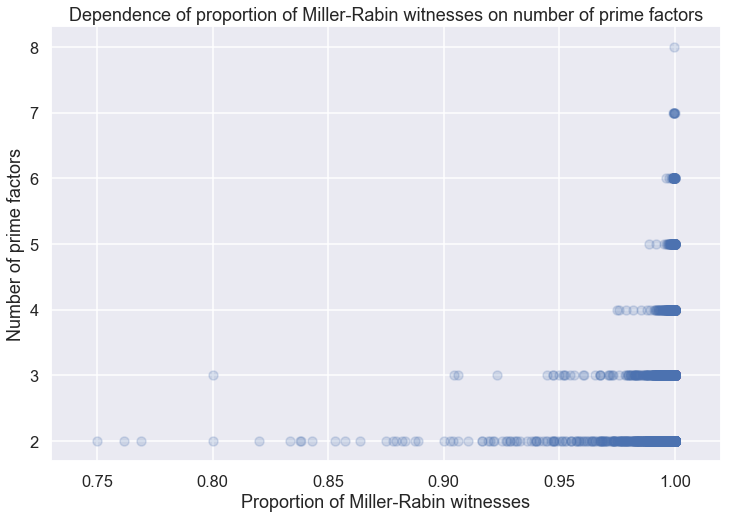

In [55]:
fractions_of_witnesses = np.array(fractions_of_witnesses)

plt.figure(figsize=(12, 8))
plt.title('Dependence of proportion of Miller-Rabin witnesses on number of prime factors')
plt.xlabel('Proportion of Miller-Rabin witnesses')
plt.ylabel('Number of prime factors')

plt.scatter(fractions_of_witnesses[:, 0], fractions_of_witnesses[:, 2], alpha=0.2);
print(sps.pearsonr(fractions_of_witnesses[:, 0], fractions_of_witnesses[:, 2]))

(0.12319141981002583, 3.164192996200981e-14)


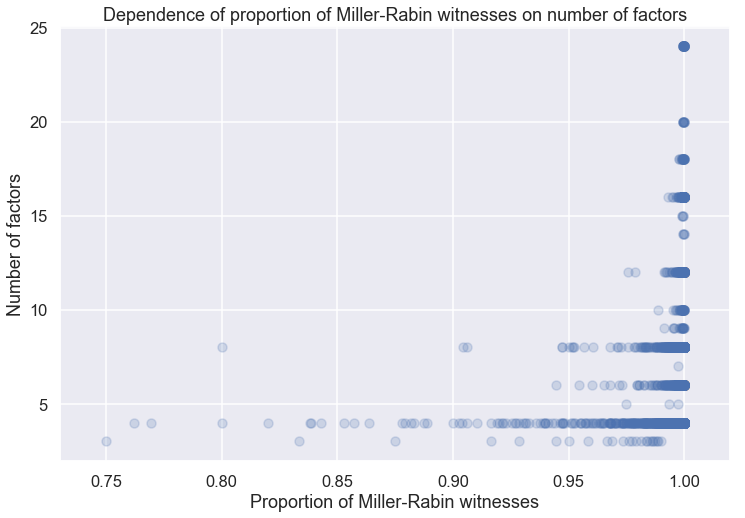

In [56]:
fractions_of_witnesses = np.array(fractions_of_witnesses)

plt.figure(figsize=(12, 8))
plt.title('Dependence of proportion of Miller-Rabin witnesses on number of factors')
plt.xlabel('Proportion of Miller-Rabin witnesses')
plt.ylabel('Number of factors')

plt.scatter(fractions_of_witnesses[:, 0], fractions_of_witnesses[:, 3], alpha=0.2);
print(sps.pearsonr(fractions_of_witnesses[:, 0], fractions_of_witnesses[:, 3]))

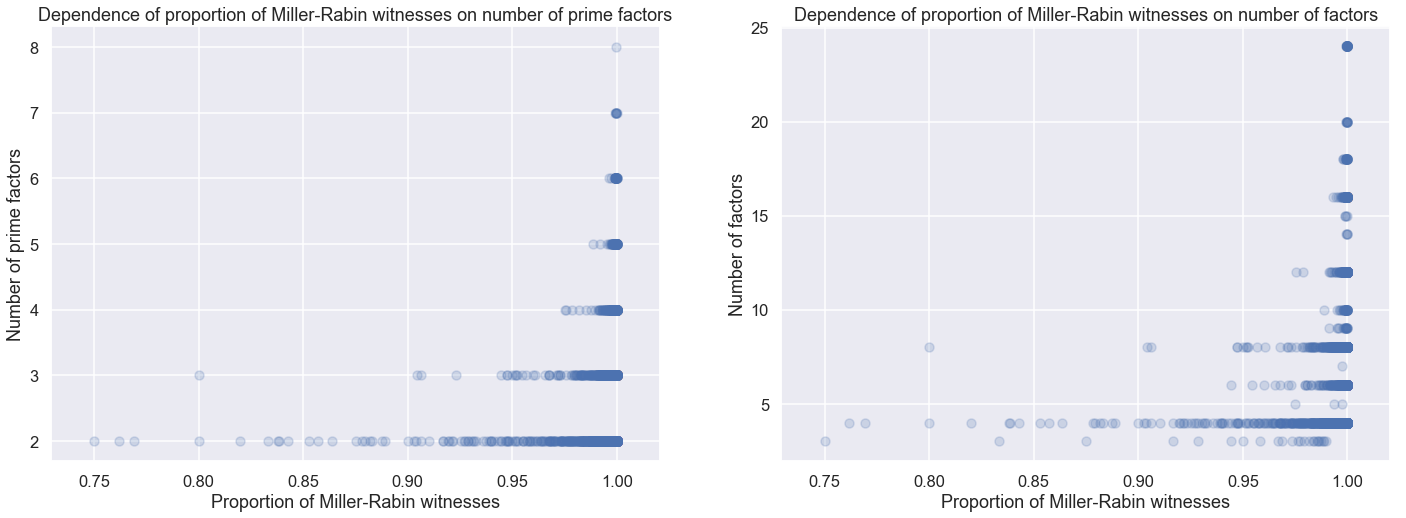

In [59]:
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.title('Dependence of proportion of Miller-Rabin witnesses on number of prime factors')
plt.xlabel('Proportion of Miller-Rabin witnesses')
plt.ylabel('Number of prime factors')
plt.scatter(fractions_of_witnesses[:, 0], fractions_of_witnesses[:, 2], alpha=0.2);

plt.subplot(1, 2, 2)
plt.title('Dependence of proportion of Miller-Rabin witnesses on number of factors')
plt.xlabel('Proportion of Miller-Rabin witnesses')
plt.ylabel('Number of factors')
plt.scatter(fractions_of_witnesses[:, 0], fractions_of_witnesses[:, 3], alpha=0.2);